<a href="https://colab.research.google.com/github/imcanugur/covid-prediction-with-clinical-spectrograms/blob/master/covid_prediction_with_clinical_spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
ruchi798_covid19_pulmonary_abnormalities_path = kagglehub.dataset_download('ruchi798/covid19-pulmonary-abnormalities')

print('Data source import complete.')

100%|██████████| 132M/132M [00:01<00:00, 127MB/s]

Extracting files...


Data source import complete.


In [2]:

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
!pip install opencv-python
!pip install tensorflow
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.preprocessing.image as image
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pathlib import Path
from skimage.io import imread

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 985.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 11.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [7]:
def create_dataset(img_folders,IMG_WIDTH,IMG_HEIGHT, label):
    img_data_array=[]
    class_name=[]
    n=0
    for dirname, _, filenames in os.walk(img_folders):
        for filename in filenames:
            img_path= os.path.join(dirname, filename)
            # read the image
            image = cv2.imread(img_path)
            # BGR is converted to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_WIDTH,IMG_HEIGHT))
            # convert image to numpy array
            image = np.array(image)
            image = image.astype('float32')
            # normalization
            image /= 255
            img_data_array.append(image)
            class_name.append(label)
            n+=1

    return img_data_array, class_name, n

In [8]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

noncovid_dir = os.path.join(ruchi798_covid19_pulmonary_abnormalities_path, 'Spectrograms/(Real) Non-Covid/')
covid_dir = os.path.join(ruchi798_covid19_pulmonary_abnormalities_path, 'Spectrograms/(Real) Covid/')

noncovid_img, noncovid_target, num_noncovid = create_dataset(noncovid_dir, IMG_WIDTH, IMG_HEIGHT, 'noncovid')
covid_img, covid_target, num_covid = create_dataset(covid_dir, IMG_WIDTH, IMG_HEIGHT, 'covid')

In [9]:
X = noncovid_img + covid_img
y = noncovid_target + covid_target
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

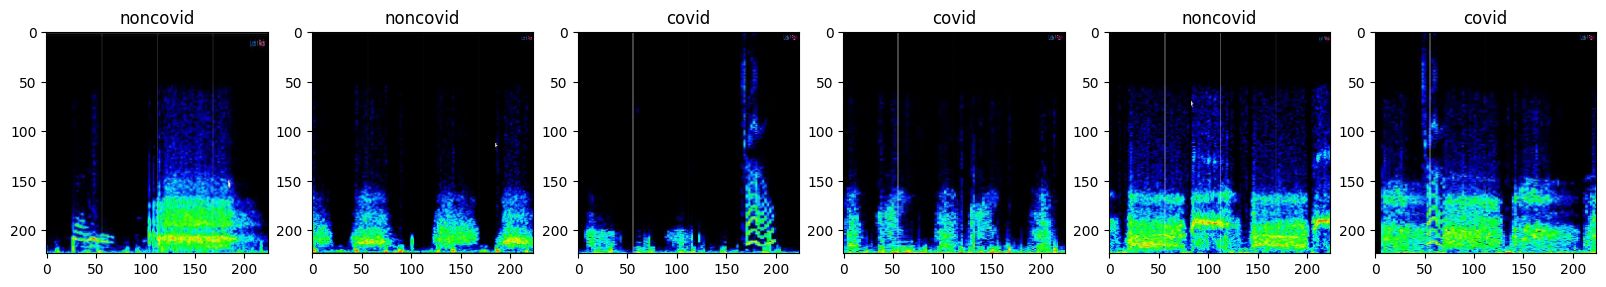

In [10]:
plt.figure(figsize=(20,20))
for i in range(6):
    ax=plt.subplot(1,6,(i+1))
    plt.imshow(X[i])
    ax.title.set_text(y[i])

In [11]:
target_dict={k: v for v, k in enumerate(np.unique(y))}
print(target_dict)
y = [target_dict[y[i]] for i in range(len(y))]
y =np.array(y)
X = np.array(X)

{np.str_('covid'): 0, np.str_('noncovid'): 1}


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train)

In [13]:
model_checkpoint = ModelCheckpoint('best_mod.h5', save_best_only=True, monitor='accuracy')
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=4)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam",metrics = ["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,972,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,028,353 (23.00 MB)

 Trainable params: 6,028,353 (23.00 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(32)

history = model.fit(train_dataset,
          validation_data=valid_dataset,
          epochs=2,
          callbacks=[model_checkpoint, early_stopping]
        )

Epoch 1/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8703 - loss: 0.2627

83/83 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.8714 - loss: 0.2606 - val_accuracy: 1.0000 - val_loss: 2.1601e-07
Epoch 2/2
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 7.0492e-04

83/83 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 1.0000 - loss: 7.0917e-04 - val_accuracy: 1.0000 - val_loss: 9.2971e-10
